In [1]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image

torch.set_printoptions(precision=2)  # 精简输出精度

# 生成多个锚框

In [2]:
def multibox_prior(data, area_sizes, w_h_ratios, w_h_ratios_normalization=False):
    """
        生成以每个像素为中心具有不同形状的锚框
        data图片数据，area_sizes锚框占图片面积率，w_h_ratios锚框宽高比
    """
    img_h, img_w = data.shape[-2:]
    device, num_area_sizes, num_w_h_ratios = data.device, len(area_sizes), len(w_h_ratios)
    # 每个像素点需要生成的锚框数
    num_boxes_per_pixel = num_area_sizes + num_w_h_ratios - 1
    # area_sizes，w_h_ratios 转tensor
    area_sizes_tensor = torch.tensor(area_sizes, device=device)
    w_h_ratios_tensor = torch.tensor(w_h_ratios, device=device)

    #每个像素1*1，坐标（x,y），将像素点中心定义为该像素生成锚框的中心，即锚框中心点坐标（x+0.5, y+0.5）
    offset_h, offset_w = 0.5, 0.5

    # 生成锚框的所有中心点
    center_h = torch.arange(img_h, device=device) + offset_h
    center_w = torch.arange(img_w, device=device) + offset_w
    # 生成img所有坐标点的锚框中心坐标，每个点的y值center_y_anchor，每个点的x值center_x_anchor
    center_y_anchor, center_x_anchor = torch.meshgrid(center_h, center_w)
    # flatten
    center_y_anchor, center_x_anchor = center_y_anchor.reshape(-1), center_x_anchor.reshape(-1)
    
    # 生成锚框宽高，集合area_sizes和w_h_ratios都只取第一个元素和另一个集合的所有组合
    # 生成“num_boxes_per_pixel”个锚框宽和高
    if w_h_ratios_normalization is False:
        # 1、宽高未归一化，area_size为面积比，w_h_ratio为最终锚框的宽高比
        # 由下两式联立：
        # w_h_ratio = w_anchor / h_anchor
        # area_size = (w_anchor * h_anchor) / (img_w * img_h) 
        # 推出锚框宽高计算公式：
        # w_anchor = sqrt(img_w * img_h * area_size * w_h_ratio)
        # h_anchor = sqrt(img_w * img_h * area_size / w_h_ratio)
        area_img = img_w * img_h
        w_anchor = torch.cat(
            tensors=[torch.sqrt(area_img * area_sizes_tensor * w_h_ratios_tensor[0]), 
                     torch.sqrt(area_img * area_sizes_tensor[0] * w_h_ratios_tensor[1:])],
            dim=0
        )
        h_anchor = torch.cat(
            tensors=[torch.sqrt(area_img * area_sizes_tensor / w_h_ratios_tensor[0]), 
                     torch.sqrt(area_img * area_sizes_tensor[0] / w_h_ratios_tensor[1:])],
            dim=0
        )
    else:
        # 2、宽高归一化，area_size为面积比，w_h_ratio表示的宽高比是归一化后的
        # 由下两式联立：
        # w_h_ratio = (w_anchor/img_w) / (h_anchor/img_h)
        # area_size = (w_anchor * h_anchor) / (img_w * img_h) 
        # 推出锚框宽高计算公式：
        # w_anchor = img_w * sqrt(area_size * w_h_ratio)
        # h_anchor = img_h * sqrt(area_size / w_h_ratio)
        w_anchor = torch.cat(
            tensors=[torch.sqrt(area_sizes_tensor * w_h_ratios_tensor[0]), 
                     torch.sqrt(area_sizes_tensor[0] * w_h_ratios_tensor[1:])],
            dim=0
        ) * img_w
        h_anchor = torch.cat(
            tensors=[torch.sqrt(area_sizes_tensor / w_h_ratios_tensor[0]), 
                     torch.sqrt(area_sizes_tensor[0] / w_h_ratios_tensor[1:])],
            dim=0
        ) * img_h
        
    # 使用小数表示（锚框与图片宽高占比）
    w_anchor /= img_w
    h_anchor /= img_h
    center_x_anchor /= img_w
    center_y_anchor /= img_h
    # 即每个像素都要生成num_boxes_per_pixel个锚框，每个像素的锚框宽高尺寸为w_anchor，h_anchor
    # 下面要根据每个像素的具体位置为每个像素都生成出所有锚框具体位置
    
    # 相对于center的偏移(-w_anchor/2, -h_anchor/2, w_anchor/2, h_anchor/2)
    # 创建单个像素的锚框偏移张量，张量shape为 (num_boxes_per_pixel, 4)，锚框为对角坐标表示
    # 第一个维度重复img_h * img_w，第二个维度一次，得到每个像素的锚框偏移张量，
    # repeat后张量shape为 (num_boxes_per_pixel * img_h * img_w, 4)
    boxes_all_pixel_tensor = torch.stack(
        [-w_anchor, -h_anchor, w_anchor, h_anchor], 
        dim=1
    ).repeat(img_h * img_w, 1) / 2
    
    # 锚框中心坐标(center_x_anchor, center_y_anchor, center_x_anchor, center_y_anchor)
    # 每个中心点都将有“num_boxes_per_pixel”个锚框，
    # 锚框中心坐标张量shape为(img_h * img_w, 4)，所以生成含所有锚框中心的网格，
    # 需要张量内部重复，即每行元素（每个像素）重复了“num_boxes_per_pixel”次
    # repeat_interleave后张量shape为 (num_boxes_per_pixel * img_h * img_w, 4)
    boxes_center_all_pixel_tensor = torch.stack(
        [center_x_anchor, center_y_anchor, center_x_anchor, center_y_anchor], 
        dim=1
    ).repeat_interleave(num_boxes_per_pixel, dim=0)
    
    # 相加得锚框完整坐标，shape为 (num_boxes_per_pixel * img_h * img_w, 4)
    # (center_x_anchor-w_anchor/2, center_y_anchor-h_anchor/2, center_x_anchor+w_anchor/2, center_y_anchor+h_anchor/2)
    boxes_all_pixel_tensor = boxes_center_all_pixel_tensor + boxes_all_pixel_tensor
    
    # 增加一个第0个维度，shape为 (1, num_boxes_per_pixel * img_h * img_w, 4)
    return boxes_all_pixel_tensor.unsqueeze(0)

In [3]:
img_catdog = Path('../data/img/catdog.jpg')

In [4]:
img = image.read_image(img_catdog.as_posix())
c, h, w = img.shape
w, h

(728, 561)

In [5]:
X = torch.rand(size=(1, c, h, w))    # 批量大小，图片通道数，图片行数，图片列数
area_sizes=[0.3, 0.1, 0.02]    # 锚框所占面积比
w_h_ratios=[1, 2, 0.5]    # 锚框宽高比
# 为图片每个像素生成指定多的锚框
Y = multibox_prior(data=X, area_sizes=area_sizes, w_h_ratios=w_h_ratios, w_h_ratios_normalization=False)
Y.shape

torch.Size([1, 2042040, 4])

In [6]:
# reshape为 (图片行数，图片列数，锚框数，对角表示的坐标)
boxes = Y.reshape(h, w, len(area_sizes)+len(w_h_ratios)-1, 4)
boxes[250, 450, 0, :]

tensor([0.38, 0.13, 0.86, 0.76])

In [7]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        """将对象做成list"""
        obj = obj or default_values
        return obj if isinstance(obj, (list, tuple)) else [obj]

    labels = _make_list(labels)
    colors = _make_list(colors, default_values=['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = utils.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center', 
                      fontsize=9, color=text_color, bbox=dict(facecolor=color, lw=0))

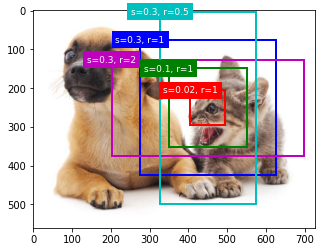

In [8]:
bbox_scale = torch.tensor((w, h, w, h))
img = to_pil_image(img)
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 450, :, :] * bbox_scale,
            [f's={area_sizes[0]}, r={w_h_ratios[0]}', 
             f's={area_sizes[1]}, r={w_h_ratios[0]}', 
             f's={area_sizes[2]}, r={w_h_ratios[0]}', 
             f's={area_sizes[0]}, r={w_h_ratios[1]}',
             f's={area_sizes[0]}, r={w_h_ratios[2]}'])

# 交并比

In [9]:
def box_iou(boxes1, boxes2):
    """
        计算两组框列表中两两成对的交并比
        （boxes1, boxes2 均为对角标记坐标）
    """
    box_area = lambda boxes: (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    # 该操作连续触发两次广播，第一次广播相当于矩阵1升维后复制扩充该维度【复制len(矩阵2)个】，再使矩阵2触发一次广播
    # inter_upperlefts = torch.max(boxes1[:, None, :2].repeat_interleave(len(boxes2), dim=1), boxes2[:, :2])
    # inter_lowerrights = torch.min(boxes1[:, None, 2:].repeat_interleave(len(boxes2), dim=1), boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areas和union_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

# 将真实边界框分配给锚框

![v30_1](../data/img/v30_1.png)

In [10]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU, shape为(num_anchors, num_gt_boxes)
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量(锚框到真实边界框映射表)
    anchors_bbox_map = torch.full(size=(num_anchors,), fill_value=-1, dtype=torch.long, device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)    # iou满足阈值的锚框索引
    box_j = indices[max_ious >= iou_threshold]    # iou满足阈值的类别索引
    anchors_bbox_map[anc_i] = box_j
    # 此刻已将满足阈值的锚框标记好真实类别
    
    # 极端情况下，有可能大多数锚框均对某一真实类iou最大，此刻可以适当压制这一类，使其余真实类可以最少被一个锚框匹配出
    # 标记为“无效”行列的填充为-1
    col_discard = torch.full(size=(num_anchors,), fill_value=-1)
    row_discard = torch.full(size=(num_gt_boxes,), fill_value=-1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)    # 不写维度dim，返回flattened索引
        box_idx = (max_idx % num_gt_boxes).long()    # 类别索引
        anc_idx = (max_idx / num_gt_boxes).long()    # 锚框索引
        anchors_bbox_map[anc_idx] = box_idx    # 此真实类别找到iou表现最好的锚框，标记此锚框的类别
        # 将该行列值置为-1，即压制该类别在其余锚框的iou表现，使其余真实类可以最少被一个锚框匹配出
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

# 标记类别和偏移量

![v30_2](../data/img/v30_2.png)

In [11]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """
        计算锚框与真实边框的偏移量
        anchors, assigned_bb 均为对角表示坐标
    """
    c_anc = utils.box_corner_to_center(anchors)
    c_assigned_bb = utils.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], dim=1)
    return offset

In [12]:
def multibox_target(anchors, labels):
    """
        使用真实边界框标记锚框
        标记锚框的类别和偏移量。 将背景类别的索引设置为零，然后将新类别的整数索引递增1
    """
    batch_size, anchors = labels.shape[0], anchors.squeeze(dim=0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        # 每一个label元素： (类别，左上x，左上y，右下x，右下y)
        label = labels[i, :, :]
        # 给每一个锚框分配类别
        anchors_bbox_map = assign_anchor_to_bbox(ground_truth=label[:, 1:], anchors=anchors, device=device)
        # bbox_mask的shape为 (num_anchors, 4)，有匹配类别值是1，无匹配类别值是0
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # 将真实类标签和分配的边界框坐标初始化为零（包含背景类别）
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        has_class_anchors_ids = torch.nonzero(anchors_bbox_map >= 0)    # 有正类别的锚框索引
        class_ids = anchors_bbox_map[has_class_anchors_ids]    # 有正类别的锚框对应的类别索引
         # 将有正类别的锚框的类别索引+1，其余为默认值背景负类0
        class_labels[has_class_anchors_ids] = label[class_ids, 0].long() + 1   
        # 将有正类别的锚框的类别所在边框坐标收集在assigned_bb中
        assigned_bb[has_class_anchors_ids] = label[class_ids, 1:]    
        # 计算偏移量
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask    # 仅计算有正类标记的锚框与label的offset
        
        # 收集当前批的偏移量、锚框的正类蒙板、正类
        # offset和bbox_mask的shape都是(num_anchors, 4); class_labels的shape是(num_anchors,)
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))   
        batch_class_labels.append(class_labels)
        
    # bbox_offset和bbox_mask的shape都是(batch_size, num_anchors * 4)
    # class_labels的shape是(batch_size, num_anchors)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

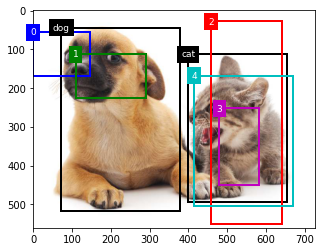

In [13]:
ground_truth = torch.tensor(
    [[0, 0.1, 0.08, 0.52, 0.92],
    [1, 0.55, 0.2, 0.9, 0.88]]
)
anchors = torch.tensor(
    [[0, 0.1, 0.2, 0.3], 
     [0.15, 0.2, 0.4, 0.4],
     [0.63, 0.05, 0.88, 0.98], 
     [0.66, 0.45, 0.8, 0.8],
     [0.57, 0.3, 0.92, 0.9]]
)

fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [15]:
bbox_offset, bbox_mask, class_labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

In [16]:
class_labels

tensor([[0, 1, 2, 0, 2]])

In [17]:
bbox_mask

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [18]:
bbox_offset

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

In [19]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = utils.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] / 10 * anc[:, 2:]) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = utils.box_center_to_corner(pred_bbox)
    return predicted_bbox

# 使用非极大值抑制预测边界框
![v30_3](../data/img/v30_3.png)

In [21]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序，非极大值抑制置信度高且iou小的框"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的索引
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: 
            break
        # iou的shape为(len(B[1:]),)
        iou = box_iou(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        # 将iou低于阈值的 B[1:]索引留存下来，继续下一回合
        ids = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[ids + 1]    # ids是从当前B的第二个元素开始，所以索引+1
    return torch.tensor(keep, device=boxes.device)

In [23]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5, pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        # 第i批数据
        # cls_prob的shape为(num_cls, num_anchors), offset_pred的shape为(num_anchors, 4)
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        # 每个锚框的最大正类置信度和类别索引（索引从第一个正类开始，不包含负类背景0）
        conf, class_id = torch.max(cls_prob[1:], dim=0)    # conf和class_id的shape都为(num_anchors,)
        predicted_bb = offset_inverse(anchors, offset_pred)    # 根据锚框和偏移量转换为预测边界框（新锚框）
        keep = nms(predicted_bb, conf, nms_threshold)    # 非极大值抑制后，保留下来的边界框索引，是锚框/新锚框的索引向量

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))    # 保留的锚框索引和所有的锚框索引合并
        uniques, counts = combined.unique(return_counts=True)    # 返回不重复的值（锚框索引值）的向量，和出现次数的向量
        non_keep = uniques[counts == 1]    # 只出现一次的值（锚框索引值）的向量
        all_id_sorted = torch.cat((keep, non_keep))    # 保留下来的锚框索引和认为是背景的锚框索引拼接，得到有序的锚框全索引
        class_id[non_keep] = -1    # 将包含nms没通过的不保留的类别预测均重置为背景类别
        class_id = class_id[all_id_sorted]    # 按照all_id_sorted索引顺序重置类别顺序
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]    # 重置置信度和新锚框顺序
        # pos_threshold是一个用于非背景预测的阈值
        below_pos_threshold_idx = (conf < pos_threshold)
        class_id[below_pos_threshold_idx] = -1    # 将pos_threshold置信度不到阈值的预测都认定为背景类别
        conf[below_pos_threshold_idx] = 1 - conf[below_pos_threshold_idx]    # 将低于阈值的正类置信度都重置为负类背景的置信度（1-conf）
        # 拼接 类别、置信度、新锚框 ，pred_info的shape为(num_class_id, 1+1+4)
        pred_info = torch.cat((class_id.unsqueeze(1), conf.unsqueeze(1), predicted_bb), dim=1)
        out.append(pred_info)
    # 多批数据合并
    return torch.stack(out)

In [24]:
anchors = torch.tensor(
    [[0.1, 0.08, 0.52, 0.92], 
     [0.08, 0.2, 0.56, 0.95],
     [0.15, 0.3, 0.62, 0.91], 
     [0.55, 0.2, 0.9, 0.88]]
)
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor(
    [[0, 0, 0, 0],    # 背景的预测概率
     [0.9, 0.8, 0.7, 0.1],    # 狗的预测概率
     [0.1, 0.2, 0.3, 0.9]]    # 猫的预测概率
)  

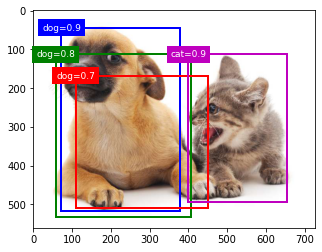

In [25]:
fig = plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale, ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [31]:
output = multibox_detection(
    cls_probs.unsqueeze(dim=0),
    offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0),
    nms_threshold=0.5
)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

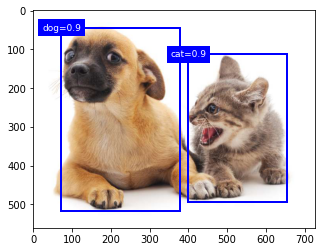

In [32]:
fig = plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In [43]:
# nms_threshold 改为 0.6，将iou大于0.6的去掉（dog_0.7与dog_0.9的iou大于nms_threshold，dog_0.7被dog_0.9抑制）

In [44]:
output = multibox_detection(
    cls_probs.unsqueeze(dim=0),
    offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0),
    nms_threshold=0.6
)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [ 0.00,  0.70,  0.15,  0.30,  0.62,  0.91],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95]]])

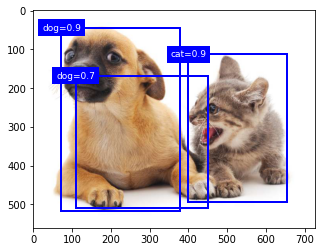

In [45]:
fig = plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)